In [243]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import time

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch

# 加载并查看数据

In [244]:
# 从google云盘加载数据
from google.colab import drive 
!gdown --id '1q9K5N4q3YLg511FjsTS0H6U8UztDKzzv' --output data.zip
!unzip data.zip

Downloading...
From: https://drive.google.com/uc?id=1q9K5N4q3YLg511FjsTS0H6U8UztDKzzv
To: /content/data.zip
24.2MB [00:00, 112MB/s] 
Archive:  data.zip
replace data/mnist_train.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/mnist_train_labels.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/ReadMe.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/usps_train.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/usps_train_labels.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [245]:
mnist_data_image = loadmat("data/mnist_train.mat")
mnist_date_lable = loadmat("data/mnist_train_labels.mat")

In [246]:
mnist_data_image = np.array(mnist_data_image['mnist_train'])
mnist_date_lable = np.array(mnist_date_lable['mnist_train_labels'])
print("测试图片shape：", np.shape(mnist_data_image))
print("测试图片标签shape：", np.shape(mnist_date_lable))

测试图片shape： (60000, 784)
测试图片标签shape： (60000, 1)


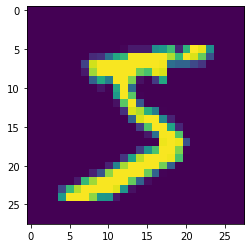

In [247]:
fig = plt.figure()
plt.imshow(mnist_data_image[0].reshape((28,28)))
plt.show()

# 数据处理

In [248]:
num = mnist_data_image.shape[0]
mnist_data_image = mnist_data_image.reshape(-1,28,28,1) # 一般channel在最后面。如果这里是(-1,1,28,28),后面transforms.ToTensor，会把1放到中间
mnist_date_lable = mnist_date_lable.reshape(num,).astype('long')              # 因为后面的交叉熵需要1D，long类型
print("image shape:",np.shape(mnist_data_image))
print("image lable shape:",np.shape(mnist_date_lable))

image shape: (60000, 28, 28, 1)
image lable shape: (60000,)


In [249]:
# 数据的5/6用于训练，1/6用于测试
num = mnist_data_image.shape[0]
train_mnist_data_image = mnist_data_image[:int(num/6*5)]
test_mnist_data_image = mnist_data_image[int(num/6*5):]
train_mnist_date_lable = mnist_date_lable[:int(num/6*5)]
test_mnist_date_lable = mnist_date_lable[int(num/6*5):]
# print(np.shape(train_mnist_data_image))

In [250]:
# transforms进行以下操作：PIL.Image/numpy.ndarray与Tensor的相互转化；归一化；对PIL.Image进行裁剪、缩放等操作。
train_transform = transforms.Compose([
    transforms.ToTensor(), # 将数据转换成 Tensor，并把数值 normalize 到 [0,1] 
])
test_transform = transforms.Compose([                              
    transforms.ToTensor(),
])

class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [251]:
# 通过torch.utils.data.DataLoader来定义新的迭代器
batch_size = 100
train_set = ImgDataset(train_mnist_data_image, train_mnist_date_lable, train_transform)
test_set = ImgDataset(test_mnist_data_image, test_mnist_date_lable, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [252]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.size())
print(labels.size())

torch.Size([100, 1, 28, 28])
torch.Size([100])


# cnn 模型

In [253]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [1, 28, 28]
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3),  # 6个3*3的filter   # [6,26,26]
            nn.MaxPool2d(2, 2),                    # [6,13,13]
            nn.Conv2d(6, 16, 3), # 16个6*3*3的filter# [16,11,11] 
            nn.MaxPool2d(2, 2),                    # [16,5,5]
        )
        self.fc = nn.Sequential(
            nn.Linear(16*5*5, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        # print(out.size())
        return self.fc(out)

# 训练&测试

In [259]:
model = Classifier()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 15

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    test_acc = 0.0
    test_loss = 0.0

    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model(data[0]) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1]) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            test_pred = model(data[0])
            batch_loss = loss(test_pred, data[1])

            test_acc += np.sum(np.argmax(test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            test_loss += batch_loss.item()

        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Test Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), test_acc/test_set.__len__(), test_loss/test_set.__len__()))

[001/015] 1.02 sec(s) Train Acc: 0.747806 Loss: 0.008318 | Test Acc: 0.885161 loss: 0.003867
[002/015] 1.00 sec(s) Train Acc: 0.914559 Loss: 0.002815 | Test Acc: 0.922581 loss: 0.002567
[003/015] 1.01 sec(s) Train Acc: 0.942179 Loss: 0.002045 | Test Acc: 0.914839 loss: 0.002599
[004/015] 1.00 sec(s) Train Acc: 0.954053 Loss: 0.001571 | Test Acc: 0.957419 loss: 0.001660
[005/015] 1.02 sec(s) Train Acc: 0.964120 Loss: 0.001268 | Test Acc: 0.953548 loss: 0.001670
[006/015] 1.05 sec(s) Train Acc: 0.968508 Loss: 0.001071 | Test Acc: 0.940645 loss: 0.001872
[007/015] 1.01 sec(s) Train Acc: 0.974187 Loss: 0.000830 | Test Acc: 0.948387 loss: 0.001698
[008/015] 1.00 sec(s) Train Acc: 0.977801 Loss: 0.000697 | Test Acc: 0.950968 loss: 0.001734
[009/015] 1.01 sec(s) Train Acc: 0.980382 Loss: 0.000565 | Test Acc: 0.963871 loss: 0.001496
[010/015] 1.01 sec(s) Train Acc: 0.986577 Loss: 0.000465 | Test Acc: 0.953548 loss: 0.001857
[011/015] 1.01 sec(s) Train Acc: 0.990449 Loss: 0.000350 | Test Acc: 0

# usps 手写数字识别

过程和上面类似。只不过Mnist是28\*28，usps是16\*16

In [260]:
########## 加载数据 ####################3

usps_data_image = loadmat("data/usps_train.mat")
usps_date_lable = loadmat("data/usps_train_labels.mat")

usps_data_image = np.array(usps_data_image['usps_train'])
usps_date_lable = np.array(usps_date_lable['usps_train_labels'])
# print("测试图片shape：", np.shape(usps_data_image))
# print("测试图片标签shape：", np.shape(usps_date_lable))


# fig = plt.figure()
# plt.imshow(usps_data_image[0].reshape((16,16)))
# plt.show()

num = usps_data_image.shape[0]
usps_data_image = usps_data_image.reshape(-1,16,16,1).astype('float32') # 一般channel在最后面。如果这里是(-1,1,28,28),后面transforms.ToTensor，会把1放到中间
usps_date_lable = usps_date_lable.reshape(num,).astype('long')              # 因为后面的交叉熵需要1D，long类型
print("image shape:",np.shape(usps_data_image))
print("image lable shape:",np.shape(usps_date_lable))

# for i,num in  enumerate(usps_date_lable):
#   if num == 10:
#     fig = plt.figure()
#     plt.imshow(usps_data_image[i].reshape((16,16)))
#     plt.show()
#     break
# 烦人，label分类没有从数字0开始。
usps_date_lable = usps_date_lable -1

########### 数据的5/6用于训练，1/6用于测试 ##################
num = usps_data_image.shape[0]
train_usps_data_image = usps_data_image[:int(num/6*5)]
test_usps_data_image = usps_data_image[int(num/6*5):]
train_usps_date_lable = usps_date_lable[:int(num/6*5)]
test_usps_date_lable = usps_date_lable[int(num/6*5):]
# print(np.shape(train_usps_data_image))

image shape: (4649, 16, 16, 1)
image lable shape: (4649,)


In [261]:
########## 数据转换成Tensor并normalize；使用Dataset，使用自定义的迭代器。#############

train_transform = transforms.Compose([
    transforms.ToTensor(), # 将数据转换成 Tensor，并把数值 normalize 到 [0,1] 
])
test_transform = transforms.Compose([                              
    transforms.ToTensor(),
])

class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X


# 通过torch.utils.data.DataLoader来定义新的迭代器
batch_size = 100
train_set = ImgDataset(train_usps_data_image, train_usps_date_lable, train_transform)
test_set = ImgDataset(test_usps_data_image, test_usps_date_lable, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [262]:
############## 因为维度不同，这里重新定义下CNN模型 ###########################
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [1, 16, 16]
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3),  # 6个3*3的filter   # [6,14,14]
            nn.MaxPool2d(2, 2),                    # [6,7,7]
            # nn.Conv2d(6, 16, 3), # 16个6*3*3的filter# [16,5,5] 
            # nn.MaxPool2d(2, 2),                    # [16,2,2]
        )
        self.fc = nn.Sequential(
            nn.Linear(6*7*7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        # print(out.size())
        return self.fc(out)

In [263]:
################# 训练并测试模型 #########################
model = Classifier()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 15

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    test_acc = 0.0
    test_loss = 0.0

    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model(data[0]) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1]) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            test_pred = model(data[0])
            batch_loss = loss(test_pred, data[1])

            test_acc += np.sum(np.argmax(test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            test_loss += batch_loss.item()

        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Test Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), test_acc/test_set.__len__(), test_loss/test_set.__len__()))

[001/015] 1.04 sec(s) Train Acc: 0.715023 Loss: 0.009122 | Test Acc: 0.882581 loss: 0.003902
[002/015] 1.03 sec(s) Train Acc: 0.912752 Loss: 0.003139 | Test Acc: 0.904516 loss: 0.003077
[003/015] 1.00 sec(s) Train Acc: 0.933144 Loss: 0.002181 | Test Acc: 0.930323 loss: 0.002439
[004/015] 1.04 sec(s) Train Acc: 0.950955 Loss: 0.001639 | Test Acc: 0.927742 loss: 0.002532
[005/015] 0.99 sec(s) Train Acc: 0.962055 Loss: 0.001312 | Test Acc: 0.945806 loss: 0.002036
[006/015] 1.00 sec(s) Train Acc: 0.971864 Loss: 0.001009 | Test Acc: 0.949677 loss: 0.001873
[007/015] 1.03 sec(s) Train Acc: 0.976510 Loss: 0.000830 | Test Acc: 0.952258 loss: 0.001645
[008/015] 1.01 sec(s) Train Acc: 0.981673 Loss: 0.000576 | Test Acc: 0.956129 loss: 0.001684
[009/015] 1.03 sec(s) Train Acc: 0.985803 Loss: 0.000496 | Test Acc: 0.961290 loss: 0.001754
[010/015] 1.04 sec(s) Train Acc: 0.980898 Loss: 0.000582 | Test Acc: 0.950968 loss: 0.001685
[011/015] 1.01 sec(s) Train Acc: 0.986319 Loss: 0.000450 | Test Acc: 0